In [1]:
"""
notebook: 1.5.-leibold-data-modeling_randomForest.jpynb

author: Christian Leibold

created/updated at: 2025-11-30

intention: create preprocessing pipeline to prepare data from concat joblib. 
           create pipline to use SMOTEEN resampling with random forest model to create a first baseline model. 

content:
---------
-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2024 as base for this notebook 
-> create a pipeline with most important preprocessing steps
-> NEW: create a pipline for SMOTEEEN resampling + random forest model
-> NEW: use RandomSearchCV to optimize hyperparamethers
-> save model to local storage
"""

'\nnotebook: 1.5.-leibold-data-modeling_randomForest.jpynb\n\nauthor: Christian Leibold\n\ncreated/updated at: 2025-11-30\n\nintention: create preprocessing pipeline to prepare data from concat joblib. \n           use random forest model with smote to create a first baseline model. \n\ncontent:\n---------\n-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2024 as base for this notebook \n-> create a pipeline with most important preprocessing steps\n-> NEW: use GridSearchCV to optimize hyperparamethers\n-> create random forest model + smote resampling\n-> save model to local storage\n\n'

In [1]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')

# pipeline compatibel classes
from road_accidents_pipeline import RemoveIrrelevantCols         # removes some unnecessary columns
from road_accidents_pipeline import RearrangeCatCols             # bundle veh classes together to higher-tier classes
from road_accidents_pipeline import ConditionalMultiQuantImputer # impute missing values of quantiative variables via distr. on cat var
from road_accidents_pipeline import ConditionalCatImputer        # impute missing values of categorcial variables on target distribution
from road_accidents_pipeline import AggrLocaSplit                # aggregation of loca intersections incl. oneHotEncoding 
from road_accidents_pipeline import SupervisedEncoderWrapper     # wrapper for supervised encoders like CatBoostEncoder or TargetEncoder to make it work in pipeline
from road_accidents_pipeline import RemoveIdCols                 # removes ind_temp_id and acc_num after aggregation
from road_accidents_pipeline import TrigonometricEncoder         # encoding for cyclic variables lice acc_month or acc_hour
from road_accidents_pipeline import SafeColumnSelector           # makes sure only to use existing columns in pipeline

# scaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# encoder
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder

# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, f1_score, recall_score
import shap

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# resampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# model classifier
from sklearn.ensemble import RandomForestClassifier

# hyperparameter optimization
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# little helper
from cleaning_utils import distinguish_cols, print_col_categories
import time



In [19]:
# -------------------------------------------------------------------------------------------------
# read in joblib with concatenated data
# -------------------------------------------------------------------------------------------------
df_ori = load(r'..\..\..\temp_data\1.2-leibold-data-preprocessing_concat.joblib')
#df = df.loc[(df['acc_year']==2024) | (df['acc_year']==2023)]
#df = df.sample(n=10000)

print(df_ori.shape)
display(df_ori.head(3))

(762666, 44)


,acc_num,ind_place,ind_cat,ind_severity,ind_sex,ind_trip,ind_secu1,ind_secu2,ind_location,ind_action,...,veh_id,loca_road_cat,loca_traffic_circul,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed,loca_is_intersection
0,201900000001,2,2,2,2,0,1,0,<NA>,<NA>,...,138 306 524,1,3,10.0,1,2.0,1.0,1,70.0,0
1,201900000001,1,1,2,2,5,1,0,<NA>,<NA>,...,138 306 524,1,3,10.0,1,2.0,1.0,1,70.0,0
2,201900000001,1,1,1,1,0,1,0,<NA>,<NA>,...,138 306 525,1,3,10.0,1,2.0,1.0,1,70.0,0


In [25]:
# -------------------------------------------------------------------------------------------------
# create sample dataframe respecting ind_severity distribution and using rows from all years
# -------------------------------------------------------------------------------------------------
# Example proportion
prop = 0.5  

# Filter years 2019–2023 -> 2024 then shall be used to pretend to be "new" data
df_filtered = df_ori[df_ori['acc_year'].between(2019, 2023)]

# Compute target sample size
target_size = int(len(df_filtered) * prop)

# Step 1: Split by year
samples = []
n_years = df_filtered['acc_year'].nunique()

for year, df_year in df_filtered.groupby('acc_year'):
    # Equal share per year
    year_target_size = target_size // n_years

    # Step 2: Stratified sampling within year by ind_severity
    df_year_sample = (
        df_year
        .groupby('ind_severity', group_keys=False)
        .sample(
            n=None,  # let pandas compute based on frac
            frac=year_target_size / len(df_year),
            random_state=42
        )
    )
    samples.append(df_year_sample)

# Concatenate all year samples
df = pd.concat(samples)

print(df['acc_year'].value_counts())                     # equal counts per year
print(df['ind_severity'].value_counts(normalize=True))   # distribution preserved
print(df_ori['ind_severity'].value_counts(normalize=True))
print(df.shape)

acc_year
2019    61276
2020    61276
2023    61276
2021    61275
2022    61275
Name: count, dtype: int64
ind_severity
1    0.415030
2    0.406433
3    0.152958
4    0.025580
Name: proportion, dtype: float64
ind_severity
1    0.416165
2    0.406967
3    0.151538
4    0.025330
Name: proportion, dtype: float64
(306378, 44)


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306378 entries, 128040 to 638642
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   acc_num                 306378 non-null  int64         
 1   ind_place               306378 non-null  int64         
 2   ind_cat                 306378 non-null  int64         
 3   ind_severity            306378 non-null  int64         
 4   ind_sex                 306378 non-null  int64         
 5   ind_trip                306378 non-null  int64         
 6   ind_secu1               306066 non-null  Int64         
 7   ind_secu2               186228 non-null  Int64         
 8   ind_location            167909 non-null  Int64         
 9   ind_action              182774 non-null  Int64         
 10  ind_year                306378 non-null  int64         
 11  ind_age                 306378 non-null  Int64         
 12  ind_age_group           306378

In [27]:
# -------------------------------------------------------------------------------------------------
# data split
# -------------------------------------------------------------------------------------------------
# Separate features and target
X = df.drop(columns=['ind_severity'])   # predictors
y = df['ind_severity']                  # target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (245102, 43)
y_train shape: (245102,)
X_test shape: (61276, 43)
y_test shape: (61276,)


In [28]:
# -------------------------------------------------------------------------------------------------
# check missing values
# -------------------------------------------------------------------------------------------------
missing_vars = X_train.isna().sum()
missing_vars = missing_vars[missing_vars > 0]
print(missing_vars)

ind_secu1                    257
ind_secu2                  95952
ind_location              110961
ind_action                 99050
acc_ambient_lightning          6
acc_atmosphere                18
acc_intersection               9
acc_collision_type          1816
veh_impact                   103
veh_maneuver               13385
loca_road_lanes             4880
loca_road_view               143
loca_road_surface_cond       182
loca_max_speed              5845
dtype: int64


In [29]:
# -------------------------------------------------------------------------------------------------
# define columns to be operated: read in columns from dictionary for later use in pipeline
# -------------------------------------------------------------------------------------------------
cols_dict = distinguish_cols(df)

cat_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict
missing_cat_cols = [col for col in cat_cols if col in X_train.columns and X_train[col].isna().any()] # Restrict to those with missing values

ohe_cols = cols_dict['oneHot_encoder']
valid_ohe_cols = [col for col in ohe_cols if col in X_train.columns] # Restrict to existing columns


⚠️ Missing columns (ignored): ['loca_road_count']


In [30]:
# -------------------------------------------------------------------------------------------------
# Full preprocessing pipeline
# -------------------------------------------------------------------------------------------------
# Pipeline with most important preprocessing steps. can be reused in other notebooks. 
# needs concatenated data as input.
# for the whole dataset takes about 11 minutes -> so try with smaller data sample first. 

# steps:
# --------------------------------------------------------
# - RemoveIrrelevantCols: Drops columns not useful for prediction.
# - ConditionalMultiQuantImputer: Imputes missing numeric values based on road category.
# - ConditionalCatImputer: Fills missing categorical values conditionally on target distribution.
# - AggrLocaSplit: Aggregates location features for intersections.
# - RemoveIdCols: Removes identifier columns used in aggregation.
# - RearrangeCatCols: merge some classes in veh categorical columns to reduce cardinatliy.
# - ColumnTransformer: Applies spline encoding, one-hot, CatBoost encoding, and scaling to features.


# Start timer
start_time = time.time()

# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='value', handle_missing='value'), columns=["acc_municipality"])
cyclical_transformer = TrigonometricEncoder({"acc_hour": 24, "acc_month": 12})

# instantiate Scaler
scaler = MinMaxScaler()

# Combine everything into one pipeline
preprocessing_pipeline = Pipeline([
    # data preparation
    ("remove_cols", RemoveIrrelevantCols(verbose=True)),

    # imputing
    ("impute_quant", ConditionalMultiQuantImputer(quant_vars=["loca_max_speed", "loca_road_lanes"],cat_var="loca_road_cat")),
    ("impute_cat", ConditionalCatImputer(var_list=cat_cols)),

    # aggregation
    ("aggregate", AggrLocaSplit(agg_features="max", agg_target="max")),
    ("remove_id_cols", RemoveIdCols(verbose=True)),

    # encoding & scaling
    ("rearrange_categories", RearrangeCatCols(verbose=True)),
    ("encode_scale", ColumnTransformer([
        ("cyclical", cyclical_transformer, ["acc_hour", "acc_month"]),  
       ("onehot", Pipeline([
            ("select", SafeColumnSelector(cols_dict['oneHot_encoder'])),
            ("encode", ohe_encoder)
        ]), slice(None)),

        ("catboost", catboost_encoder, ["acc_municipality"]),
        ("scale", scaler, cols_dict["quantitative"])
    ], remainder="passthrough"))
    
], verbose=True)


# Fit the pipeline
preprocessing_pipeline.fit(X_train, y_train)

# Transform training and test data
X_train_piped = preprocessing_pipeline.transform(X_train)
X_test_piped = preprocessing_pipeline.transform(X_test)

# Access the fitted aggregation step
aggr_step = preprocessing_pipeline.named_steps["aggregate"]

# Transform y consistently (because the aggregation step reduces row count in X -> so y must also be reduced to avoid mismatch error)
y_train_piped = aggr_step.transform_y(X_train, y_train)
y_test_piped  = aggr_step.transform_y(X_test, y_test)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")


[Pipeline] ....... (step 1 of 7) Processing remove_cols, total=   0.0s
[Pipeline] ...... (step 2 of 7) Processing impute_quant, total=  21.3s
ℹ️ ConditionalCatImputer -> Column 'ind_location' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_action' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_secu2' not found, skipping.
[Pipeline] ........ (step 3 of 7) Processing impute_cat, total=  31.2s
[Pipeline] ......... (step 4 of 7) Processing aggregate, total=   7.0s
[Pipeline] .... (step 5 of 7) Processing remove_id_cols, total=   0.0s
[Pipeline]  (step 6 of 7) Processing rearrange_categories, total=   0.2s
[Pipeline] ...... (step 7 of 7) Processing encode_scale, total=   1.2s
⏱️ Preprocessing Pipeline fit completed in 2.09 minutes


In [11]:
# --------------------------------------------------------------------------------------------------
# Random Forest Standard + class_weight="balanced"
# --------------------------------------------------------------------------------------------------
# Initialize RandomForest model
best_rf = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=10,          # let trees expand fully
    min_samples_split=2,     # default split criteria
    min_samples_leaf=1,      # default leaf size
    random_state=42,         # reproducibility
    n_jobs=-1,                # use all cores for speed
    class_weight="balanced"
)

# Fit the model
best_rf.fit(X_train_piped, y_train_piped)

# Predict on test set
y_test_pred_best = best_rf.predict(X_test_piped)
y_train_pred_best = best_rf.predict(X_train_piped)


In [31]:
# --------------------------------------------------------------------------------------------------
# modelling with pipeline
# --------------------------------------------------------------------------------------------------
# Start timer
start_time = time.time()


# build pipeline with SMOTEEN and RandomForestClassifier
model_pipeline = ImbPipeline([
                    ('resample', SMOTEENN(random_state=42)),
                    ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
                ])

# Define parameter distributions
param_dist = {
    "clf__max_depth": [10, 15, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"],
    "clf__class_weight": ["balanced", None]
}

# define StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)           

# define scrong metrics
#scoring = {'f1_macro': make_scorer(f1_score, average='macro'), 'recall_macro': make_scorer(recall_score, average='macro')}

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=10,         
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# fit the search object 
search.fit(X_train_piped, y_train_piped)

# print best parameters and scores
print("Best parameters:", search.best_params_)
print("Best CV score:", search.best_score_)

# access the best pipeline including SMOTEEN + RandomForest and take only the model step
best_rf = search.best_estimator_.named_steps["clf"]
        
# Predict on test and train set
y_test_pred_best = best_rf.predict(X_test_piped)
y_train_pred_best = best_rf.predict(X_train_piped)

y_test_proba = best_rf.predict_proba(X_test_piped)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ model fitting completed in {elapsed_minutes:.2f} minutes")

# Best parameters: {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 20, 'clf__class_weight': 'balanced'}
# Best CV score: 0.4915361608861577
# model fitting completed in 127.64 minutes

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 20, 'clf__class_weight': 'balanced'}
Best CV score: 0.4915361608861577
⏱️ model fitting completed in 127.64 minutes


✅ RandomForest Results
Accuracy train: 0.6533030594318672
Accuracy test: 0.6093645046609545

Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.78      0.76     25313
           2       0.70      0.48      0.57     24807
           3       0.35      0.54      0.43      9355
           4       0.17      0.35      0.23      1564

    accuracy                           0.61     61039
   macro avg       0.49      0.54      0.50     61039
weighted avg       0.65      0.61      0.62     61039



Predicted,1,2,3,4
Actual,,,,
1,19631,2783,2332,567
2,5733,11956,6168,950
3,805,2269,5057,1224
4,110,179,724,551


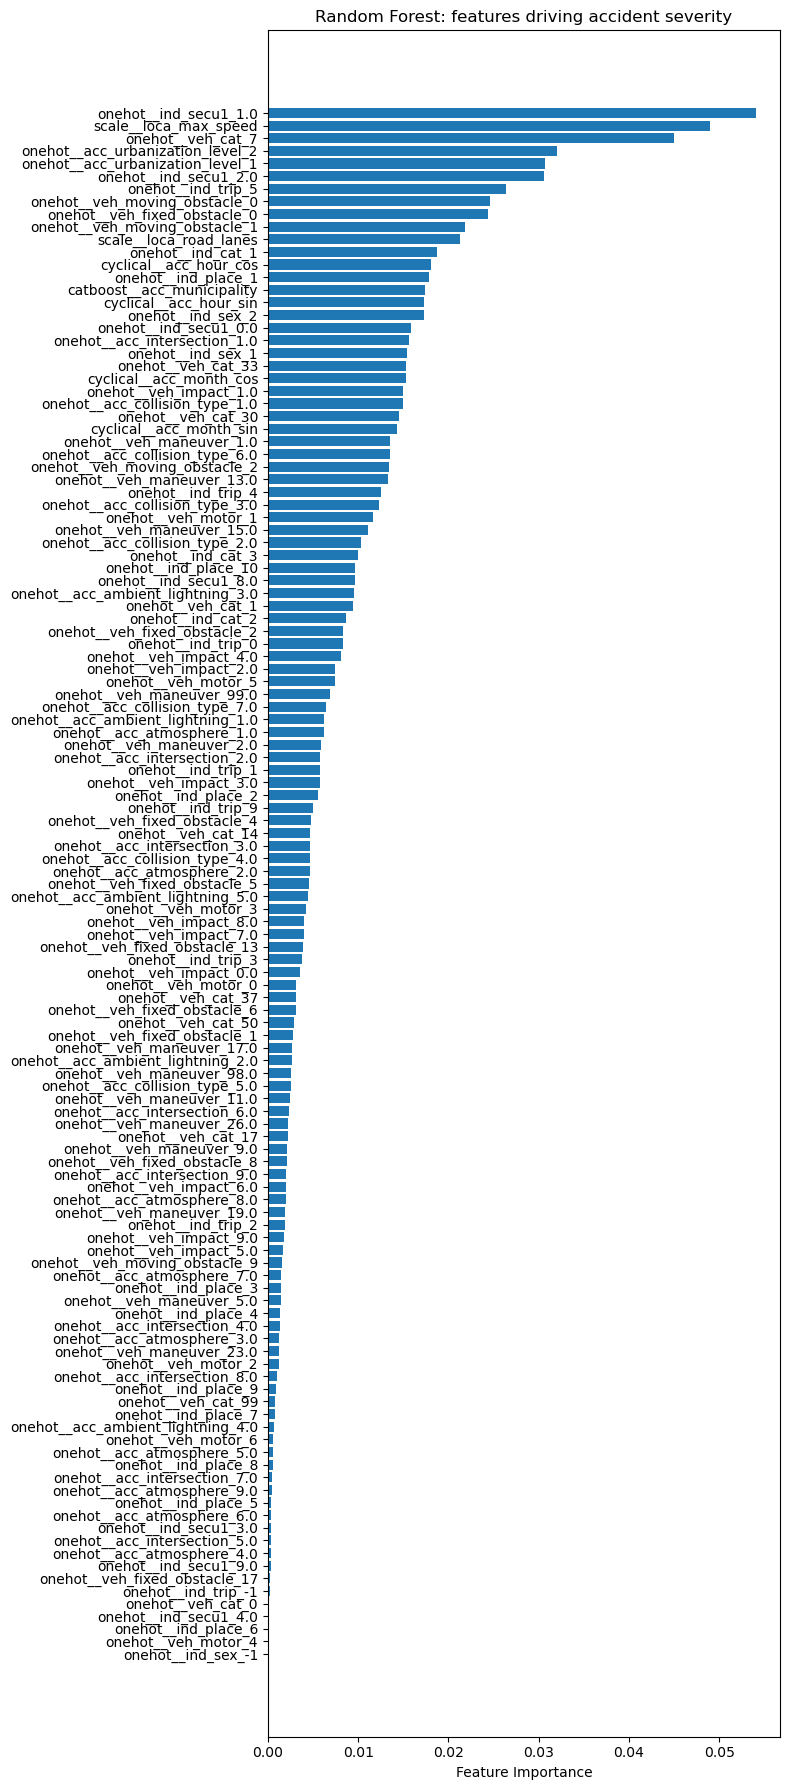

In [43]:
# --------------------------------------------------------------------------------------------------
# Evaluate performance
# --------------------------------------------------------------------------------------------------
print("✅ RandomForest Results")

# accuracy score to check if overfitted
print("Accuracy train:", accuracy_score(y_train_piped, y_train_pred_best))
print("Accuracy test:", accuracy_score(y_test_piped, y_test_pred_best))

# classifiction report
print("\nClassification Report:\n", classification_report(y_test_piped, y_test_pred_best))

# confustion matrix
display(pd.crosstab(y_test_piped, y_test_pred_best, rownames=["Actual"], colnames=["Predicted"]))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


# --------------------------------------------------------------------------------------------------
# Feature importance
# --------------------------------------------------------------------------------------------------
# pipline has np.array as output -> for feature_names a pd.DataFrame must be created to plot feature_importances_
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)

# Get feature importances from the trained RandomForest
importances = best_rf.feature_importances_
#feature_names = X_train_smote.columns

# Sort by importance
indices = np.argsort(importances)[::-1][:150]  # top 150

plt.figure(figsize=(8, 18))
plt.barh(range(len(indices)), importances[indices][::-1], align="center", height=0.8)
plt.yticks(range(len(indices)), feature_names[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest: features driving accident severity")
plt.tight_layout()
plt.show()

In [42]:
# --------------------------------------------------------------------------------------------------
# print out all Feature importances in table
# --------------------------------------------------------------------------------------------------
feature_importances = pd.Series(importances, index=X_train_piped_df.columns).sort_values(ascending=False)
fi_df = feature_importances.to_frame(name="importance")
fi_df = fi_df.sort_values("importance", ascending=False)

pd.set_option("display.max_rows", None)   # show all rows
#print(feature_importances)
display(fi_table)
pd.reset_option("display.max_rows")


,importance
onehot__ind_secu1_1.0,0.054041
scale__loca_max_speed,0.048950
onehot__veh_cat_7,0.044956
onehot__acc_urbanization_level_2,0.032051
onehot__acc_urbanization_level_1,0.030714
onehot__ind_secu1_2.0,0.030592
onehot__ind_trip_5,0.026413
onehot__veh_moving_obstacle_0,0.024578
onehot__veh_fixed_obstacle_0,0.024397
onehot__veh_moving_obstacle_1,0.021823


In [33]:
# --------------------------------------------------------------------------------------------------
# check propabilities for each individual and class
# --------------------------------------------------------------------------------------------------
proba_df = pd.DataFrame(
    y_test_proba,
    columns=[f"class_{c}" for c in best_rf.classes_]
)

proba_df.head()


,class_1,class_2,class_3,class_4
0,0.813020,0.100797,0.038053,0.048131
1,0.355513,0.289563,0.248365,0.106560
2,0.008383,0.771361,0.192740,0.027517
3,0.017831,0.545638,0.316783,0.119749
4,0.889629,0.048518,0.033013,0.028840


In [34]:
# --------------------------------------------------------------------------------------------------
# safe model
# --------------------------------------------------------------------------------------------------
#dump(rf_smote, "../../models/model_rf_smote")
dump(best_rf, "C:/Users/Christian/Documents/model_rf_randomSearch_smoteen_kfoldCV.joblib", compress=3)


['C:/Users/Christian/Documents/model_rf_randomSearch_smoteen_kfoldCV.joblib']

In [44]:
assert X_test_piped.shape[1] == len(feature_names)
print("Classes:", best_rf.classes_)  # e.g., array([1, 2, 3, 4])

class4_index = np.where(best_rf.classes_ == 4)[0][0] 
print("Class 4 index:", class4_index)


Classes: [1 2 3 4]
Class 4 index: 3


In [ ]:
# --------------------------------------------------------------------------------------------------
# SHAP values for minority classes
# --------------------------------------------------------------------------------------------------
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_piped, progress_bar=True)

# shap_values is a list: one array per class
shap_class3 = np.abs(shap_values[3]).mean(axis=0)
shap_class4 = np.abs(shap_values[4]).mean(axis=0)

fi_class3 = pd.Series(shap_class3, index=X_val.columns).sort_values(ascending=False)
fi_class4 = pd.Series(shap_class4, index=X_val.columns).sort_values(ascending=False)

print("SHAP importance for class 3:\n", fi_class3)
print("SHAP importance for class 4:\n", fi_class4)

In [31]:
# --------------------------------------------------------------------------------------------------
# SHAP values in general
# --------------------------------------------------------------------------------------------------
explainer = shap.TreeExplainer(best_rf)

X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)
X_train_piped_df_sample = X_train_piped_df.sample(100, random_state=42)

X_test_piped_df = pd.DataFrame(X_test_piped, columns=feature_names)
X_test_piped_df_sample = X_test_piped_df.sample(100, random_state=42)

sample_index = X_test_piped_df_sample.index

shap_values_train = explainer.shap_values(X_train_piped_df_sample)
shap_values_test = explainer.shap_values(X_test_piped_df_sample)

shap_values_class1 = shap_values_test[0]
shap_values_class2 = shap_values_test[1]
shap_values_class3 = shap_values_test[2]
shap_values_class4 = shap_values_test[3]


<Figure size 640x480 with 0 Axes>

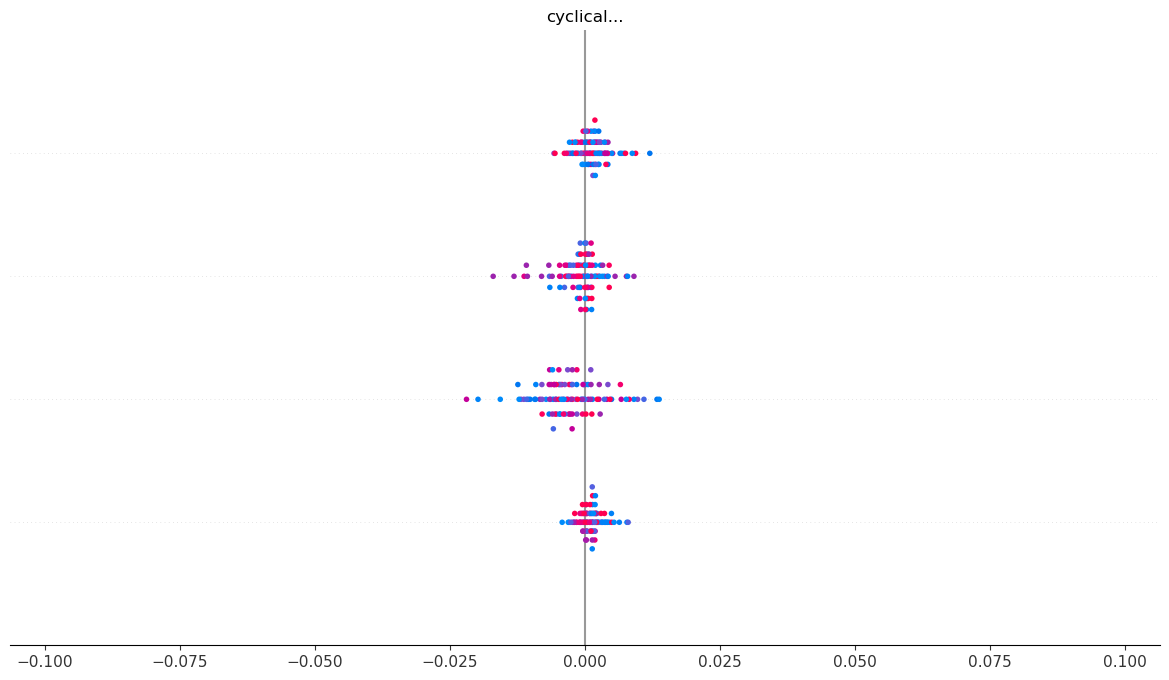

In [22]:
shap.summary_plot(shap_values_train, X_train_piped_df_sample, feature_names=feature_names)
